In [1]:
from helpers import Helpers
from valloss import ValLoss
from alpha_beta import AlphaBeta
from time_per_step import TimePerStep
from plots import plot, plot_attn, plot_alpha_beta, plot_alpha_beta_layers

from data.runs_1d import RUNS_1D_FILTERED as RUNS_1D
from data.runs_2d import RUNS_2D_FILTERED as RUNS_2D
from data.runs_2d import RUNS_2D_LOSS_MANUAL

# SETTINGS
import sys
from os.path import abspath
source_path = abspath('..')
if not source_path in sys.path:
    sys.path.append(source_path)
from settings import ENTITY, PROJECT

if 0:
    print(f'ENTITY  = {ENTITY}')
    print(f'PROJECT = {PROJECT}')

In [2]:
# suppress pandas warnings
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=FutureWarning) 
pd.options.mode.chained_assignment = None  # default='warn'

# 1. W&B Data -> Loss

In [3]:
DEBUG = False
VERBOSE = False
OVERWRITE = False
FLIP = True

In [4]:
val_loss_instance = ValLoss(ENTITY, PROJECT, RUNS_1D, RUNS_2D, DEBUG, VERBOSE, OVERWRITE)
alpha_beta_instance = AlphaBeta(ENTITY, PROJECT, RUNS_1D, RUNS_2D, DEBUG, VERBOSE, OVERWRITE)
time_per_step_instance = TimePerStep(ENTITY, PROJECT, RUNS_1D, RUNS_2D, DEBUG, VERBOSE, OVERWRITE)

### RUNS_1D

In [5]:
loss = {run_name: val_loss_instance.get_val_loss(run_name) for run_name in RUNS_1D}
# loss

In [6]:
results = Helpers.reformat_loss(loss, diagonal=True)
# results

In [7]:
alpha_beta = {run_name: alpha_beta_instance.get_alpha_beta(run_name, diagonal=True) for run_name in RUNS_1D if not 'A-' in run_name}
# alpha_beta

In [8]:
results_alpha_beta = Helpers.reformat_alpha_beta(alpha_beta, diagonal=True)
# results_alpha_beta

In [9]:
time_per_step = {run_name: time_per_step_instance.get_time_per_step(run_name, diagonal=True) for run_name in RUNS_1D}

In [10]:
avg_time_per_step = Helpers.reformat_average_time_per_step(time_per_step)
avg_time_per_step

{'exp12A-125M-50k-ln': '0.1360',
 'exp12B-125M-50k-dyt': '0.1367 +- 0.0010',
 'exp12C-125M-50k-dyisrusp': '0.1368 +- 0.0003',
 'exp15A-125M-200k-ln': '0.1339',
 'exp15B-125M-200k-dyt': '0.1343 +- 0.0009',
 'exp15C-125M-200k-dyisrusp': '0.1345 +- 0.0003',
 'exp32A-760M-50k-ln': '0.6484',
 'exp32B-760M-50k-dyt': '0.6488 +- 0.0058',
 'exp32C-760M-50k-dyisrusp': '0.6525 +- 0.0054',
 'exp35A-760M-200k-ln': '0.6470',
 'exp35B-760M-200k-dyt': '0.6388 +- 0.0036',
 'exp35C-760M-200k-dyisrusp': '0.6438 +- 0.0043'}

### RUNS_2D

In [11]:
loss_attn = {run_name: val_loss_instance.get_val_loss(run_name, diagonal=False) for run_name in RUNS_2D}
loss_attn = {**loss_attn, **RUNS_2D_LOSS_MANUAL}
# loss_attn

In [12]:
results_attn = Helpers.reformat_loss(loss_attn, diagonal=False)
# results_attn

# 2. PLOTS

## 2a. MAIN RESULTS

In [13]:
shade = [[0.25,3], [-2,2]]

### exp12

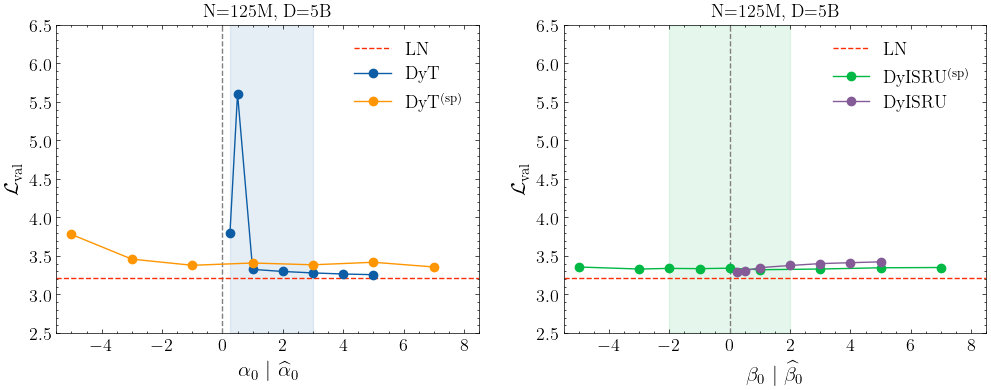

In [14]:
plot(results['125M-50k'], title='N=125M, D=5B', additional=True, shade=shade)

### exp15

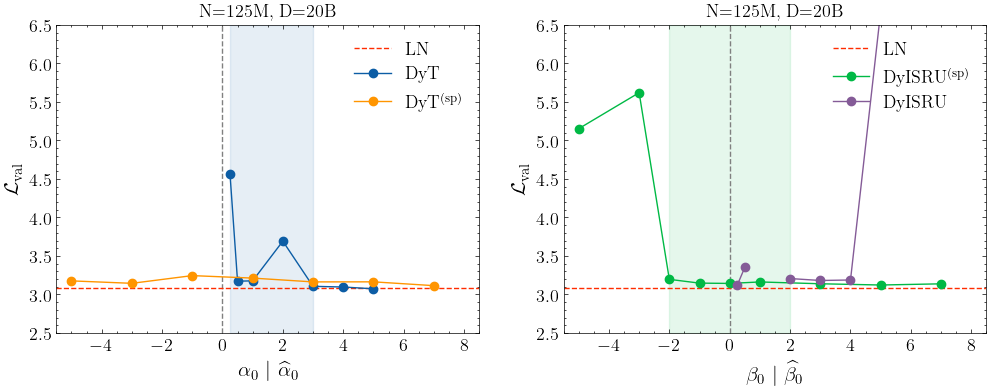

In [15]:
plot(results['125M-200k'], title='N=125M, D=20B', additional=True, shade=shade)

### exp32

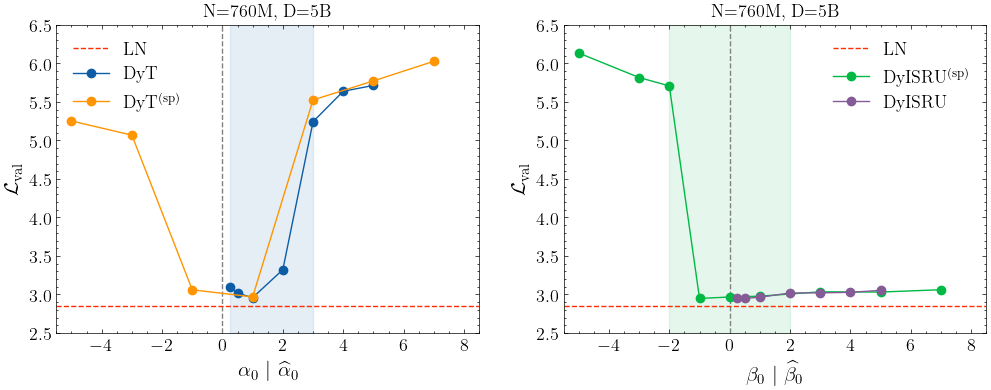

In [16]:
plot(results['760M-50k'], title='N=760M, D=5B', additional=True, shade=shade)

### exp35

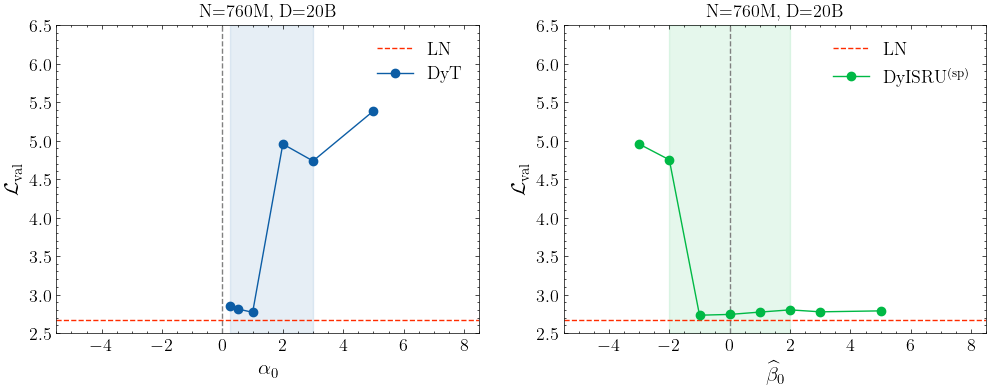

In [17]:
plot(results['760M-200k'], title='N=760M, D=20B', shade=shade)

## 2b. ATTN RESULTS

In [18]:
results_ln = {k: results[k]['ln'] for k in results}
results_ln

{'125M-50k': 3.208740472793579,
 '125M-200k': 3.078404188156128,
 '760M-50k': 2.8510634899139404,
 '760M-200k': 2.674808979034424}

In [19]:
df, metrics = {}, {}

In [20]:
import pandas as pd

REORDERED_IDX = ['L1', 'L2', 'L12', 'I1', 'I2', 'S1', 'S2']


def _comparison(a, b):
    if a > b:
        return False
    elif a < b:
        return True
    else:
        return ''

KEYWORD2EXP = {
    '125M-50k': 'exp12',
    '125M-200k': 'exp15',
    '760M-50k': 'exp32',
    '760M-200k': 'exp35',
}

def _physics_notation(_str):
    try:
        m, s = _str.split(' +- ')
    except ValueError:
        m = _str
        s = None
    
    m = f'{float(m):.3f}'
    if s is not None:
        s = f'{float(s):.3f}'[-1]
        if s == '0':
            s = '1'  # round up
        return f'{m}({s})'
    else:
        return f'{m}'

def _save_csv(_df, _save_as: str):
    from os.path import join
    if len(_save_as):
        save_path = join('tables', _save_as)
        _df.to_csv(save_path)
        print(f'> saved as {save_path}')
        
def metrics2df(_metrics, _avg_time_per_step, _keyword, _results_ln=None, save_as=''):
    time = {k.split('-')[-1]: v for k, v in _avg_time_per_step.items() if KEYWORD2EXP[_keyword] in k}
    df_metrics = pd.DataFrame(_metrics[_keyword])
    df_metrics['improvement'] = df_metrics.apply(lambda x: _comparison(x[1], x[0]), axis=1)
    df_metrics = df_metrics.reindex(index=REORDERED_IDX)
    temp_cols = df_metrics.columns[:2]
    for col in temp_cols:
        df_metrics[col] = df_metrics[col].apply(lambda x: f'{x:.3f}')
        
    df_metrics.columns = ['DyT', 'DyISRU', 'DyISRU < DyT']
    if _results_ln is not None:
        df_metrics['LN'] = ['' for _ in range(len(df_metrics))]
        df_metrics['LN'][0] = f'{_results_ln[_keyword]:.3f}'
        df_metrics = df_metrics.reindex(columns=['LN', 'DyT', 'DyISRU', 'DyISRU < DyT'])

    if _results_ln is None:
        df_metrics.loc['T'] = {'DyT': _physics_notation(time['dyt']), 'DyISRU': _physics_notation(time['dyisrusp']), 'DyISRU < DyT': ''}
    else:
        df_metrics.loc['T'] = {'LN': _physics_notation(time['ln']), 'DyT': _physics_notation(time['dyt']), 'DyISRU': _physics_notation(time['dyisrusp']), 'DyISRU < DyT': ''}

    df_metrics.index = [
        r'$\mathcal{L}_1$',
        r'$\mathcal{L}_2$',
        r'$\mathcal{L}_{12}$',
        r'$\mathcal{I}_1$',
        r'$\mathcal{I}_2$',
        r'$\mathcal{S}_1$',
        r'$\mathcal{S}_2$',
        r'$\mathcal{T}$',
    ]
    _save_csv(df_metrics, save_as)
        
    return df_metrics

### exp12

> saved as figs/exp12_main.pdf


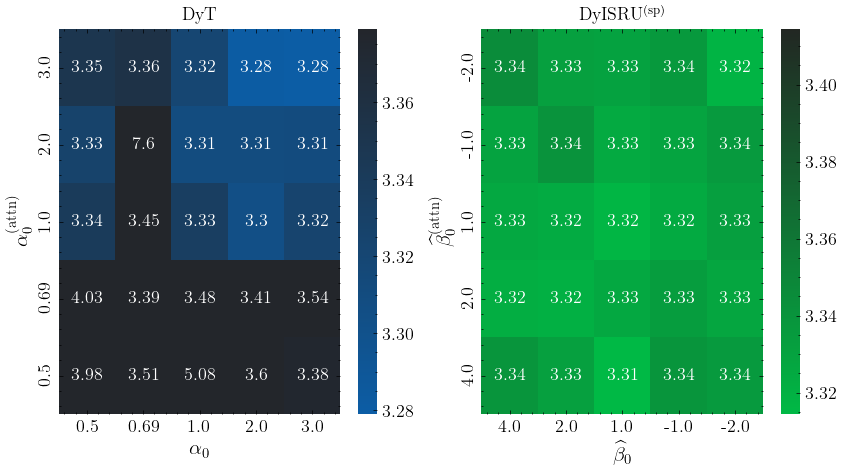

In [21]:
df['125M-50k'], metrics['125M-50k'] = plot_attn(results_attn['125M-50k'], 'main', flip=FLIP, save_as='exp12_main.pdf')

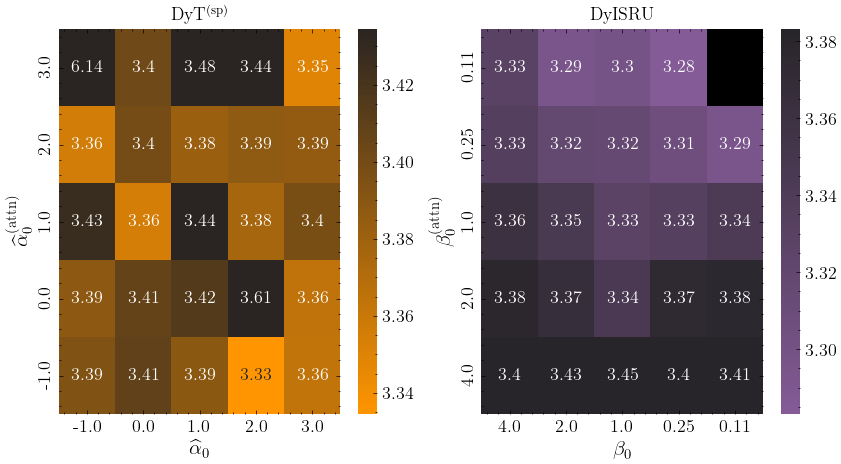

In [22]:
df['125M-50k'], metrics['125M-50k'] = plot_attn(results_attn['125M-50k'], subset='alt', flip=FLIP, df_min_col=df['125M-50k'])

In [23]:
df['125M-50k']['dyt']

,col,diag,diff
0.5,3.326576,3.975235,-64.87%
0.69,3.356083,3.391276,-3.52%
1.0,3.309915,3.334985,-2.51%
2.0,3.280943,3.309942,-2.90%
3.0,3.278993,3.278993,0.00%
global,3.278993,3.278993,0.00%


In [24]:
df['125M-50k']['dyisrusp']

,col,diag,diff
4.0,3.322495,3.339081,-1.66%
2.0,3.320768,3.320768,0.00%
1.0,3.314453,3.316936,-0.25%
-1.0,3.324754,3.328769,-0.40%
-2.0,3.318299,3.318299,0.00%
global,3.314453,3.316936,-0.25%


### exp32

> saved as figs/exp32_main.pdf


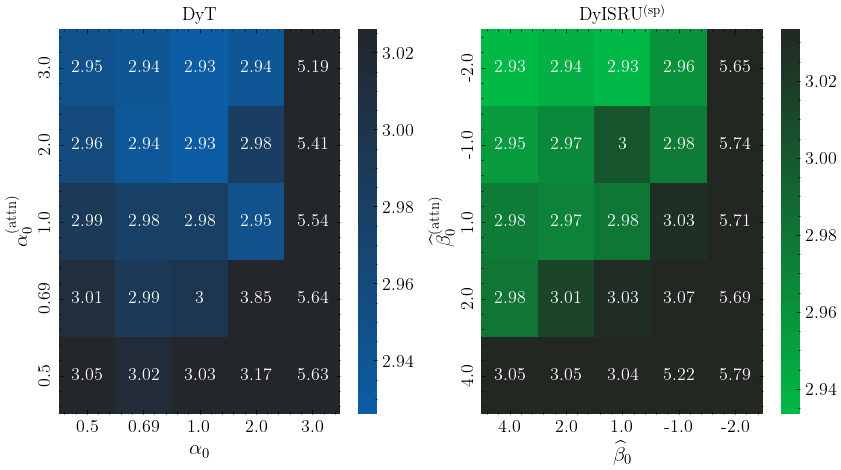

In [25]:
df['760M-50k'], metrics['760M-50k'] = plot_attn(results_attn['760M-50k'], subset='main', flip=FLIP, save_as='exp32_main.pdf')

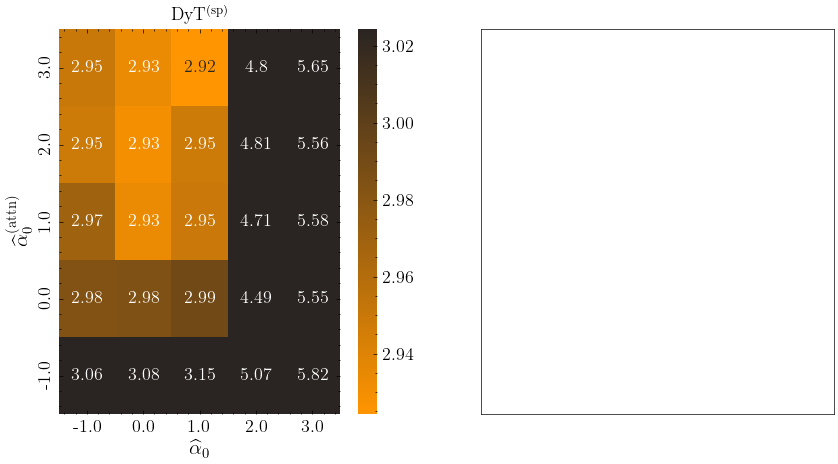

In [26]:
df['760M-50k'], _ = plot_attn(results_attn['760M-50k'], subset='alt', flip=FLIP, df_min_col=df['760M-50k'])

In [27]:
df['760M-50k']['dyt']

,col,diag,diff
0.5,2.947706,3.054095,-10.64%
0.69,2.935294,2.990543,-5.52%
1.0,2.926034,2.979844,-5.38%
2.0,2.938758,2.982035,-4.33%
3.0,5.191022,5.191022,0.00%
global,2.926034,2.979844,-5.38%


In [28]:
df['760M-50k']['dyisrusp']

,col,diag,diff
4.0,2.933476,3.049880,-11.64%
2.0,2.939857,3.013185,-7.33%
1.0,2.934282,2.978790,-4.45%
-1.0,2.960170,2.975493,-1.53%
-2.0,5.649307,5.649307,0.00%
global,2.933476,2.975493,-4.20%


### exp15

> saved as figs/exp15_main.pdf


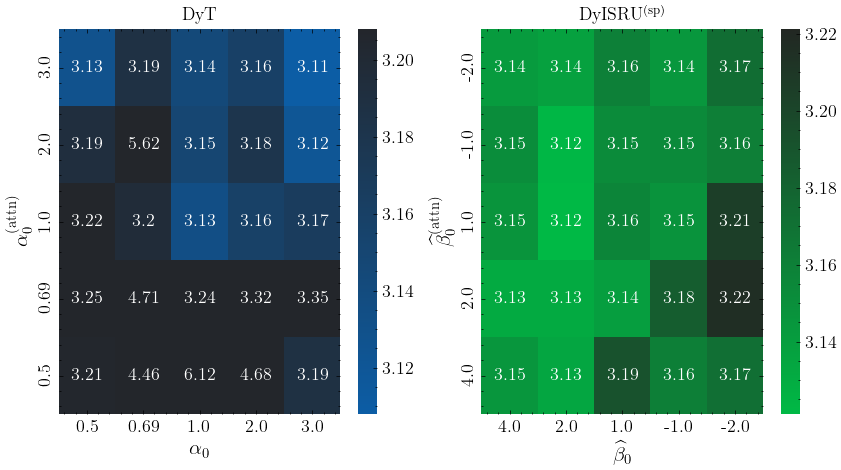

In [29]:
df['125M-200k'], metrics['125M-200k'] = plot_attn(results_attn['125M-200k'], subset='main', flip=FLIP, save_as='exp15_main.pdf')

> saved as figs/exp15_alt.pdf


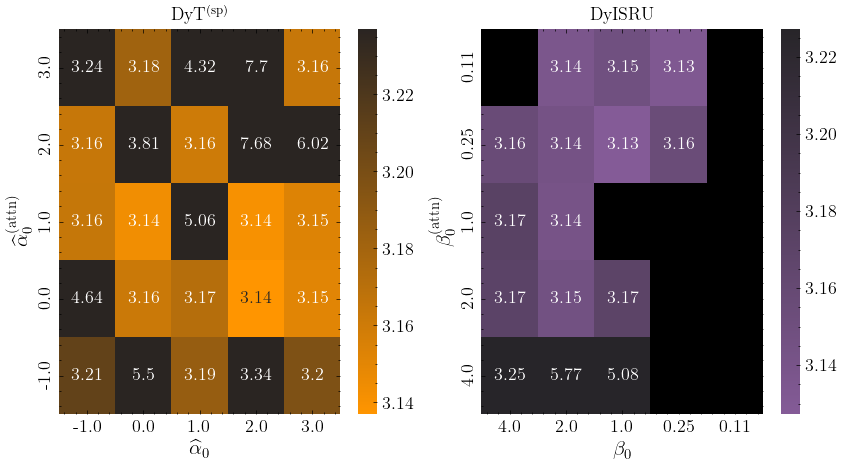

In [30]:
df['125M-200k'], _ = plot_attn(results_attn['125M-200k'], subset='alt', df_min_col=df['125M-200k'], flip=FLIP, save_as='exp15_alt.pdf')

In [31]:
df['125M-200k']['dyt']

,col,diag,diff
0.5,3.127769,3.206195,-7.84%
0.69,3.187831,4.714470,-152.66%
1.0,3.134137,3.134137,0.00%
2.0,3.158736,3.179922,-2.12%
3.0,3.107935,3.107935,0.00%
global,3.107935,3.107935,0.00%


In [32]:
df['125M-200k']['dyisrusp']

,col,diag,diff
4.0,3.131443,3.145636,-1.42%
2.0,3.121163,3.131425,-1.03%
1.0,3.139656,3.156782,-1.71%
-1.0,3.144880,3.153510,-0.86%
-2.0,3.161273,3.172782,-1.15%
global,3.121163,3.131425,-1.03%


### exp35

> saved as figs/exp35_main.pdf


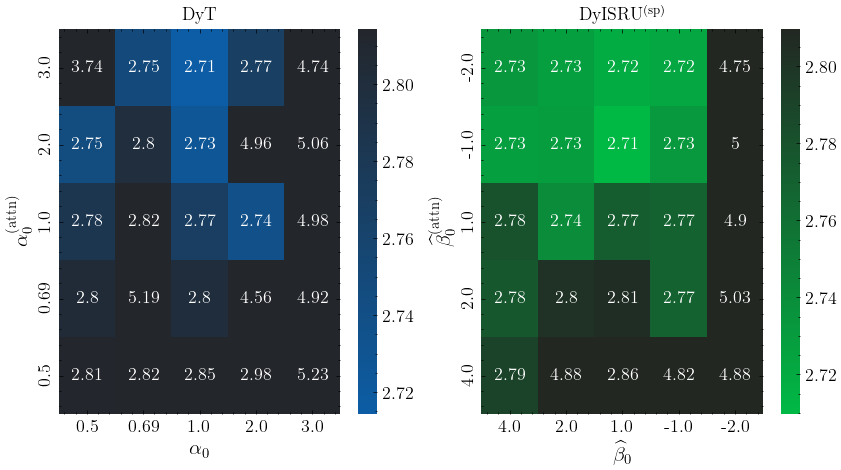

In [33]:
df['760M-200k'], metrics['760M-200k'] = plot_attn(results_attn['760M-200k'], subset='main', flip=FLIP, save_as='exp35_main.pdf')

In [34]:
df['760M-200k']['dyt']

,col,diag,diff
0.5,2.745938,2.813689,-6.78%
0.69,2.749118,5.191031,-244.19%
1.0,2.714307,2.770190,-5.59%
2.0,2.737200,4.955534,-221.83%
3.0,4.735057,4.735057,0.00%
global,2.714307,2.770190,-5.59%


In [35]:
df['760M-200k']['dyisrusp']

,col,diag,diff
4.0,2.727578,2.790898,-6.33%
2.0,2.727449,2.801556,-7.41%
1.0,2.709675,2.772764,-6.31%
-1.0,2.722209,2.732271,-1.01%
-2.0,4.750663,4.750663,0.00%
global,2.709675,2.732271,-2.26%


#### METRICS

In [36]:
metrics.keys()

dict_keys(['125M-50k', '760M-50k', '125M-200k', '760M-200k'])

In [37]:
metrics2df(metrics, avg_time_per_step, '125M-50k', results_ln, save_as='exp12.csv')

> saved as tables/exp12.csv


,LN,DyT,DyISRU,DyISRU < DyT
$\mathcal{L}_1$,3.209,3.349,3.307,True
$\mathcal{L}_2$,,3.335,3.283,True
$\mathcal{L}_{12}$,,0.015,0.023,False
$\mathcal{I}_1$,,0.000,0.000,
$\mathcal{I}_2$,,0.040,0.000,True
$\mathcal{S}_1$,,0.046,0.043,True
$\mathcal{S}_2$,,0.068,0.067,True
$\mathcal{T}$,0.136,0.137(1),0.137(1),


In [38]:
metrics2df(metrics, avg_time_per_step, '125M-200k', results_ln, save_as='exp15.csv')

> saved as tables/exp15.csv


,LN,DyT,DyISRU,DyISRU < DyT
$\mathcal{L}_1$,3.078,3.108,3.131,False
$\mathcal{L}_2$,,3.108,3.121,False
$\mathcal{L}_{12}$,,0.000,0.010,False
$\mathcal{I}_1$,,0.200,0.000,True
$\mathcal{I}_2$,,0.200,0.000,True
$\mathcal{S}_1$,,0.049,0.021,True
$\mathcal{S}_2$,,0.081,0.034,True
$\mathcal{T}$,0.134,0.134(1),0.135(1),


In [39]:
metrics2df(metrics, avg_time_per_step, '760M-50k', results_ln, save_as='exp32.csv')

> saved as tables/exp32.csv


,LN,DyT,DyISRU,DyISRU < DyT
$\mathcal{L}_1$,2.851,2.980,2.975,True
$\mathcal{L}_2$,,2.926,2.933,False
$\mathcal{L}_{12}$,,0.054,0.042,True
$\mathcal{I}_1$,,0.200,0.200,
$\mathcal{I}_2$,,0.240,0.240,
$\mathcal{S}_1$,,0.022,0.029,False
$\mathcal{S}_2$,,0.059,0.059,True
$\mathcal{T}$,0.648,0.649(6),0.652(5),


In [40]:
metrics2df(metrics, avg_time_per_step, '760M-200k', results_ln, save_as='exp35.csv')

> saved as tables/exp35.csv


,LN,DyT,DyISRU,DyISRU < DyT
$\mathcal{L}_1$,2.675,2.770,2.732,True
$\mathcal{L}_2$,,2.714,2.710,True
$\mathcal{L}_{12}$,,0.056,0.023,True
$\mathcal{I}_1$,,0.600,0.200,True
$\mathcal{I}_2$,,0.360,0.280,True
$\mathcal{S}_1$,,0.022,0.042,False
$\mathcal{S}_2$,,0.078,0.050,True
$\mathcal{T}$,0.647,0.639(4),0.644(4),


## 2c. ALPHA / BETA RESULTS

### exp12

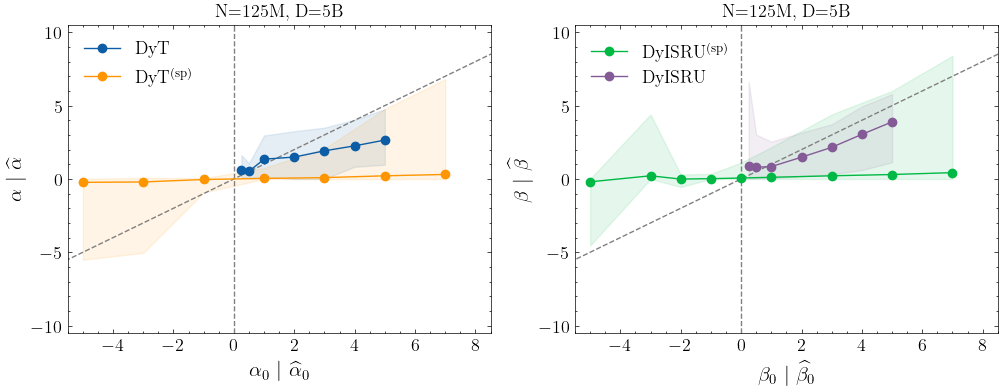

In [41]:
plot_alpha_beta(results_alpha_beta['125M-50k'], title='N=125M, D=5B', additional=True, minmax=True)

### exp15

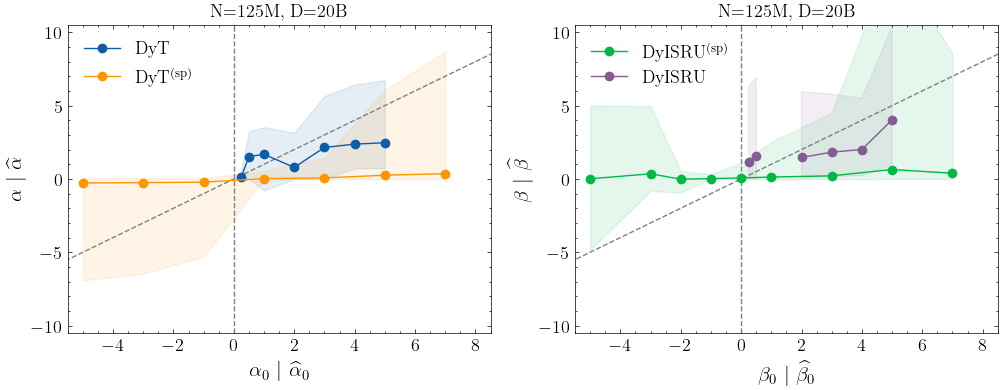

In [42]:
plot_alpha_beta(results_alpha_beta['125M-200k'], title='N=125M, D=20B', additional=True, minmax=True)

### exp32

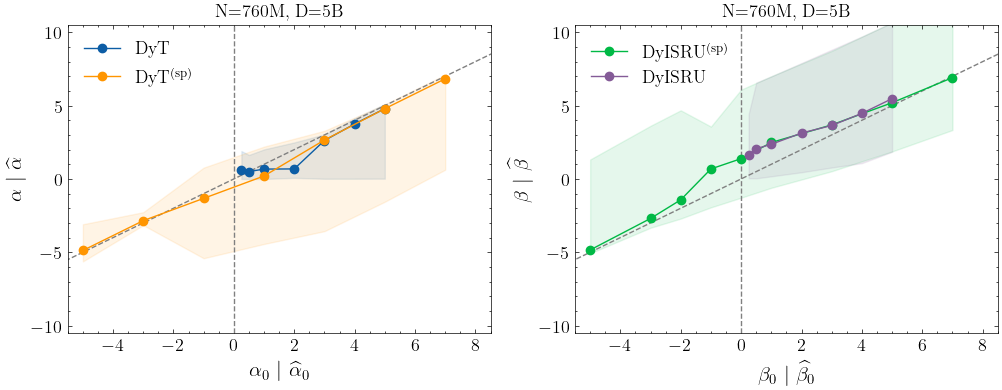

In [43]:
plot_alpha_beta(results_alpha_beta['760M-50k'], title='N=760M, D=5B', additional=True, minmax=True)

### exp35

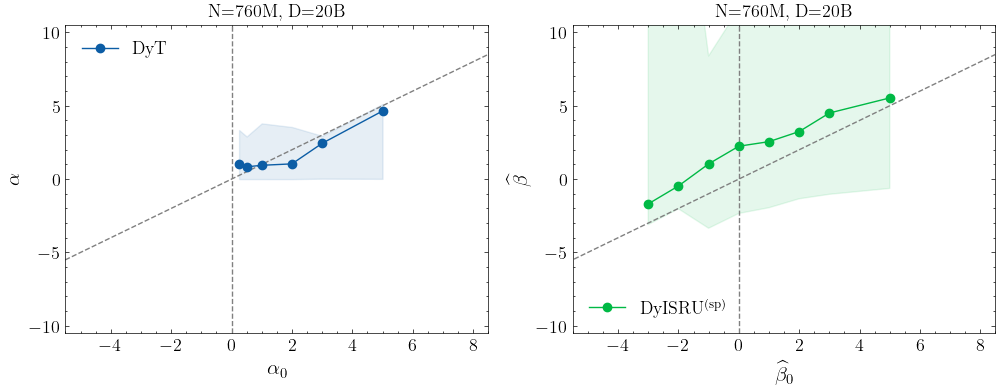

In [44]:
plot_alpha_beta(results_alpha_beta['760M-200k'], title='N=760M, D=20B', minmax=True)

## 2d. ALPHA / BETA RESULTS: LAYERS

### exp12

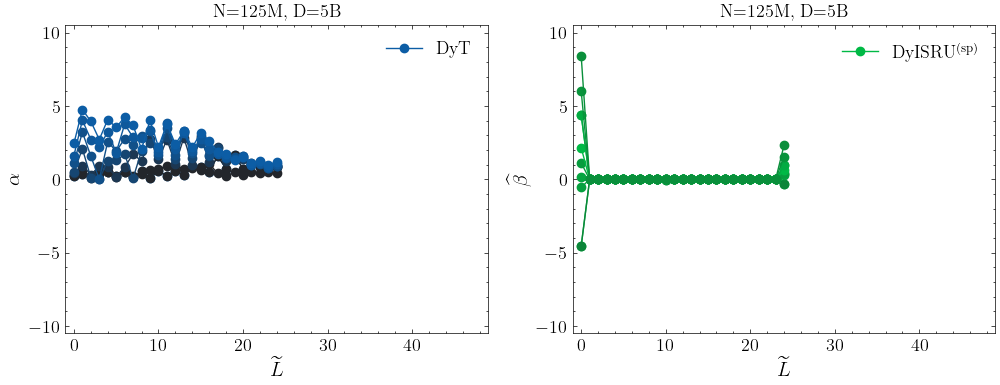

In [45]:
plot_alpha_beta_layers(
    results_alpha_beta['125M-50k'], 
    title='N=125M, D=5B', 
    minmax=True, 
    results=results['125M-50k']
)

### exp15

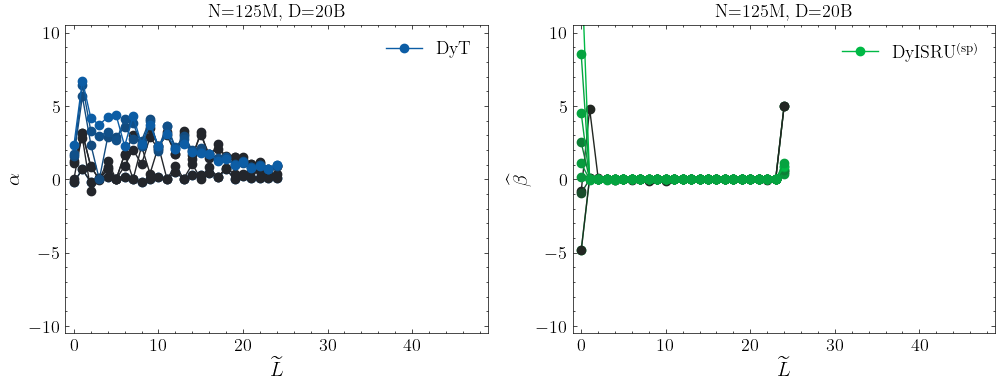

In [46]:
plot_alpha_beta_layers(
    results_alpha_beta['125M-200k'], 
    title='N=125M, D=20B', 
    minmax=True, 
    results=results['125M-200k']
)

### exp32

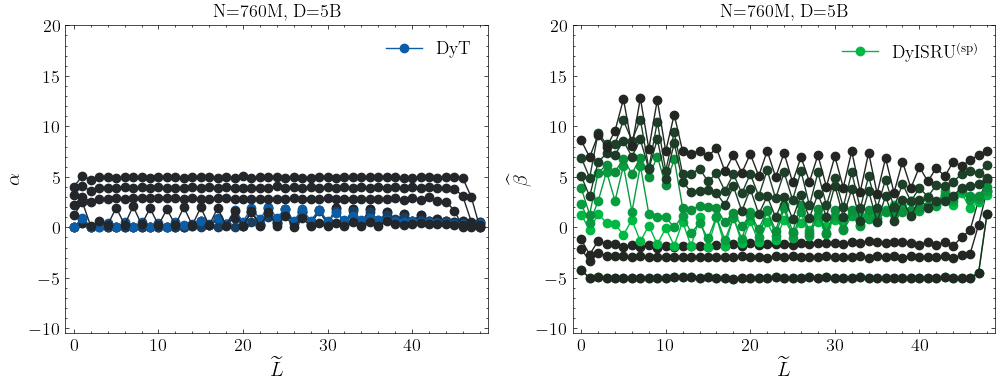

In [47]:
plot_alpha_beta_layers(
    results_alpha_beta['760M-50k'], 
    title='N=760M, D=5B', 
    ymax=20, 
    minmax=True, 
    results=results['760M-50k']
)

### exp35

> saved as figs/exp35_layers.pdf


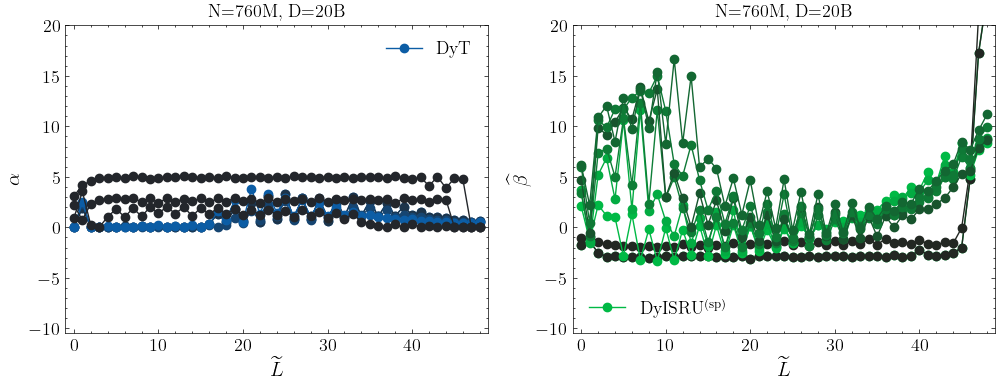

In [48]:
plot_alpha_beta_layers(
    results_alpha_beta['760M-200k'], 
    title='N=760M, D=20B', 
    ymax=20, 
    minmax=True, 
    results=results['760M-200k'], 
    save_as='exp35_layers.pdf'
)